# Import

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [5]:
import windows_utils_hf as util
import helpers

In [6]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [8]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [9]:
noh_data = pd.read_csv('../metadata/NOH_opt2_3c.csv', index_col=0)
noh_data

,Patient #,FNA biopsy,Surgery diagnosis,Bethesda,Bethesda_num,label,fold_0,fold_1,fold_2,fold_3,fold_4,patient_id,image_path,new_label
0,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
1,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
2,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
3,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
4,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134752.jpg,2
2044,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134749.jpg,2
2045,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134822.jpg,2
2046,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134601.jpg,2


In [10]:
noh_data['new_label'].value_counts().sort_index()

new_label
0     292
1     179
2    1577
Name: count, dtype: int64

In [11]:
noh_data[['patient_id', 'new_label']].drop_duplicates()['new_label'].value_counts().sort_index()

new_label
0     20
1     12
2    100
Name: count, dtype: int64

In [12]:
foldk = 'fold_3'

# Stats

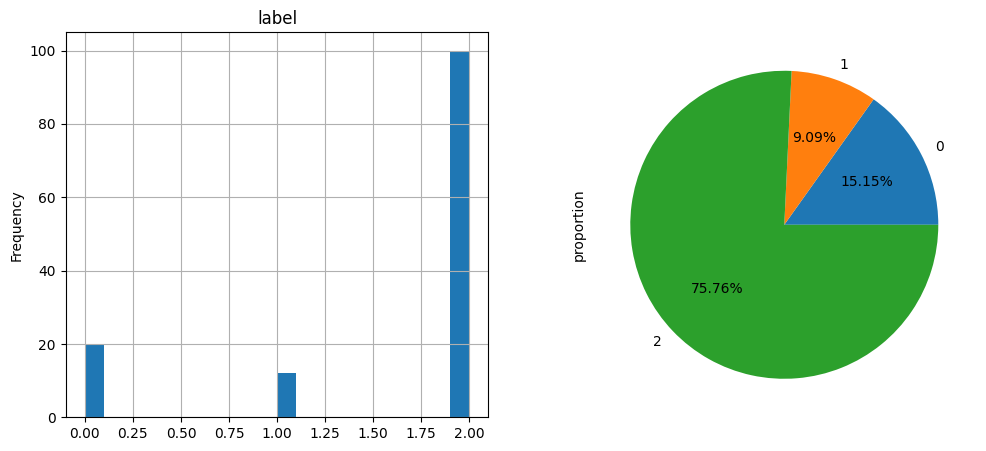

In [13]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [14]:
noh_data.groupby([foldk,'new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='patient_id').astype(int)

new_label,0,1,2
fold_3,,,
test,6,4,30
train,14,8,70


## Per Image

In [15]:
noh_data.groupby([foldk,'new_label'])['image_path'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='image_path').astype(int)

new_label,0,1,2
fold_3,,,
test,88,54,462
train,204,125,1115


In [16]:
img_ds = noh_data[['image_path', 'new_label', foldk]]
img_ds

,image_path,new_label,fold_3
0,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
2,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
3,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
4,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
...,...,...,...
2043,../data/NOH/132. LTN/IMG_20230228_134752.jpg,2,test
2044,../data/NOH/132. LTN/IMG_20230228_134749.jpg,2,test
2045,../data/NOH/132. LTN/IMG_20230228_134822.jpg,2,test
2046,../data/NOH/132. LTN/IMG_20230228_134601.jpg,2,test


## Transform

In [17]:
plt.rcParams["savefig.bbox"] = 'tight'

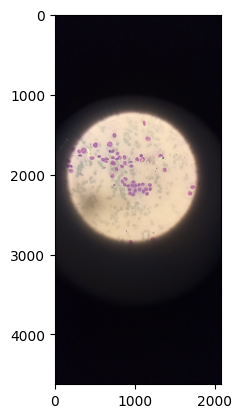

In [18]:
img_path = img_ds.iloc[0]['image_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [19]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

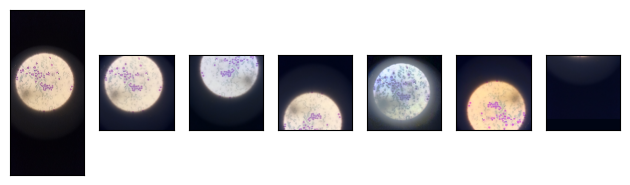

In [20]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [21]:
batch_size=16

# Dataset and DataLoader

In [22]:
# prompt: i need pytorch dataset that read from dataframe
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['image_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [23]:
train_df = img_ds[img_ds[foldk]=='train'].reset_index(drop=True)
# val_df = img_ds[img_ds[foldk]=='val'].reset_index(drop=True)
test_df = img_ds[img_ds[foldk]=='test'].reset_index(drop=True)

In [24]:
trainset = NOHThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [25]:
# valset = NOHThyroidDataset(val_df, transform=test_transform)
# valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                           shuffle=False, num_workers=8)

In [26]:
testset = NOHThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [27]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/NOH/035. NQT/IMG_20230116_113656.jpg


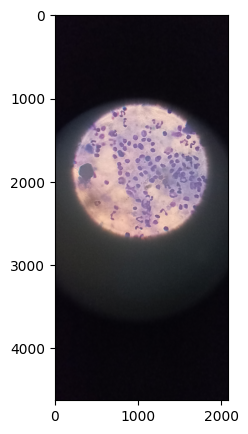

In [28]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['image_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


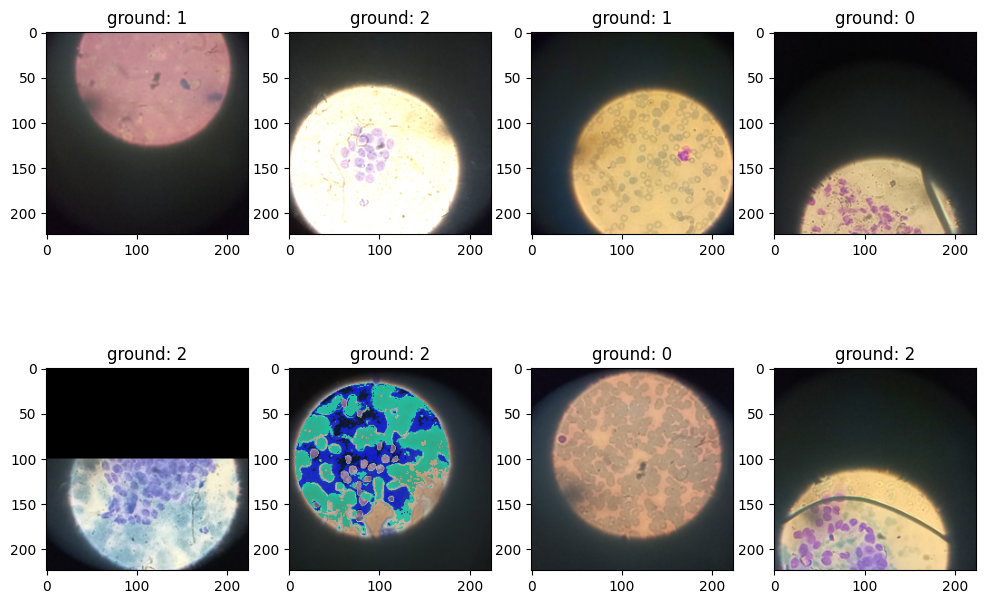

In [29]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [30]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [31]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [32]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_NOH_opt2_3c')

2024-03-12 20:56:51.120066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 20:56:51.120100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 20:56:51.121231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 20:56:51.127275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 20:56:51.913931: W tensorflow/comp

# Load model

In [33]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [34]:
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model.to(device);

In [35]:
model._fc

Linear(in_features=1280, out_features=3, bias=True)

In [36]:
num_epochs = 100
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [37]:
import torch
import torch.nn.functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [39]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [40]:
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]
    
    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [41]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())
        
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If exist model, then evaluate before write new

In [42]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [43]:
baseline_model_path = '../model/noh_opt2_3c/efficientnet-b0-clf.pt'

  0%|          | 0/38 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.8651
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        88
           1       0.91      0.72      0.80        54
           2       0.87      0.99      0.93       462

    accuracy                           0.86       604
   macro avg       0.83      0.67      0.72       604
weighted avg       0.85      0.86      0.84       604



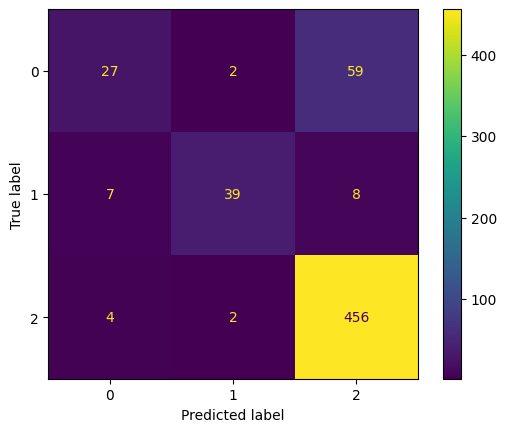

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])
Label:  2
Predicted:  2
Label:  2
Predicted:  0
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2
Label:  2
Predicted:  2


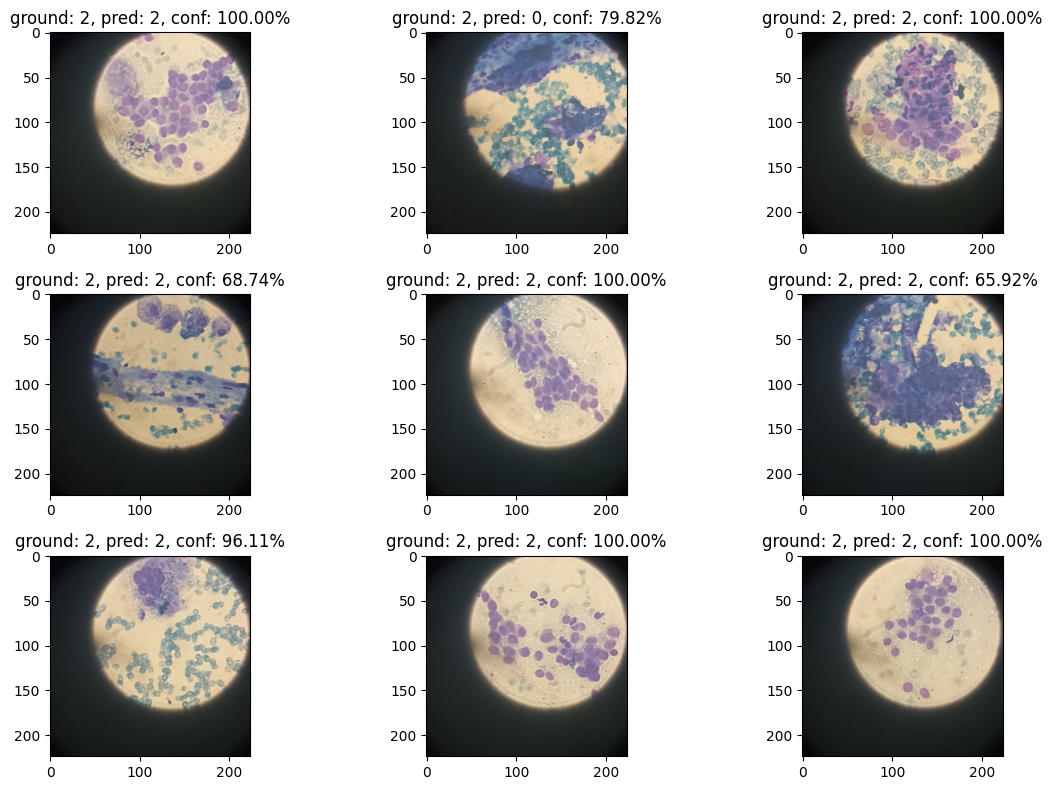

In [44]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc, _, _ = evaluate_dataset(model, testloader)
    run_predict_testset()

In [45]:
best_val_acc

0.8651315789473685

# Train model

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [44]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [45]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [46]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        evaluate_dataset(model, testloader)
        print(f'Better result, val: {best_val_acc}')
        torch.save(model.state_dict(), baseline_model_path)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch: 0 	Train Loss: 0.5560 	Train Acc: 0.7864 	Val Loss: 1.9363 	Val Acc: 0.8158


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.5039 	Train Acc: 0.8139 	Val Loss: 0.7144 	Val Acc: 0.8339


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.4902 	Train Acc: 0.8201 	Val Loss: 0.6668 	Val Acc: 0.8158


  0%|          | 0/91 [02:40<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.4294 	Train Acc: 0.8427 	Val Loss: 0.4763 	Val Acc: 0.8553


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.4522 	Train Acc: 0.8249 	Val Loss: 2.0443 	Val Acc: 0.7445


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.4526 	Train Acc: 0.8331 	Val Loss: 0.4570 	Val Acc: 0.8503


  0%|          | 0/91 [03:20<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: 0.4128 	Train Acc: 0.8503 	Val Loss: 0.7268 	Val Acc: 0.8339


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 7 	Train Loss: 0.3672 	Train Acc: 0.8798 	Val Loss: 0.8253 	Val Acc: 0.7056


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.3962 	Train Acc: 0.8503 	Val Loss: 0.5984 	Val Acc: 0.8130


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 9 	Train Loss: 0.3933 	Train Acc: 0.8558 	Val Loss: 0.8697 	Val Acc: 0.7599


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 10 	Train Loss: 0.3517 	Train Acc: 0.8729 	Val Loss: 0.5873 	Val Acc: 0.8322


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 11 	Train Loss: 0.3160 	Train Acc: 0.8777 	Val Loss: 0.5589 	Val Acc: 0.8339


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 12 	Train Loss: 0.3119 	Train Acc: 0.8894 	Val Loss: 0.6187 	Val Acc: 0.7856


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 9.0000e-05.
Epoch: 13 	Train Loss: 0.2975 	Train Acc: 0.8839 	Val Loss: 0.6435 	Val Acc: 0.7944


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 14 	Train Loss: 0.2778 	Train Acc: 0.8935 	Val Loss: 0.6755 	Val Acc: 0.7812


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 15 	Train Loss: 0.2723 	Train Acc: 0.8915 	Val Loss: 0.6870 	Val Acc: 0.8125


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 16 	Train Loss: 0.2607 	Train Acc: 0.8922 	Val Loss: 0.7091 	Val Acc: 0.8224


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

Epoch 00018: reducing learning rate of group 0 to 2.7000e-05.
Epoch: 17 	Train Loss: 0.2720 	Train Acc: 0.8997 	Val Loss: 0.7095 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 18 	Train Loss: 0.2727 	Train Acc: 0.9018 	Val Loss: 0.7097 	Val Acc: 0.8043


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 19 	Train Loss: 0.2581 	Train Acc: 0.9004 	Val Loss: 0.6948 	Val Acc: 0.8109


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 20 	Train Loss: 0.2658 	Train Acc: 0.9052 	Val Loss: 0.6905 	Val Acc: 0.8026


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 8.1000e-06.
Epoch: 21 	Train Loss: 0.2350 	Train Acc: 0.9135 	Val Loss: 0.7157 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

Epoch: 22 	Train Loss: 0.2571 	Train Acc: 0.9093 	Val Loss: 0.7248 	Val Acc: 0.8043


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 23 	Train Loss: 0.2551 	Train Acc: 0.9087 	Val Loss: 0.7139 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 24 	Train Loss: 0.2560 	Train Acc: 0.9093 	Val Loss: 0.7252 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>^
^^Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^    ^self._shutdown_workers()^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.

Epoch 00026: reducing learning rate of group 0 to 2.4300e-06.
Epoch: 25 	Train Loss: 0.2497 	Train Acc: 0.9045 	Val Loss: 0.7147 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 26 	Train Loss: 0.2497 	Train Acc: 0.9093 	Val Loss: 0.7130 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 27 	Train Loss: 0.2542 	Train Acc: 0.9073 	Val Loss: 0.7218 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 28 	Train Loss: 0.2443 	Train Acc: 0.9073 	Val Loss: 0.7282 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 7.2900e-07.
Epoch: 29 	Train Loss: 0.2507 	Train Acc: 0.9087 	Val Loss: 0.7232 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 30 	Train Loss: 0.2526 	Train Acc: 0.9045 	Val Loss: 0.7332 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>    self._shutdown_workers()    self._shutdown_workers()Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ a

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 31 	Train Loss: 0.2405 	Train Acc: 0.9100 	Val Loss: 0.7314 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 32 	Train Loss: 0.2795 	Train Acc: 0.9059 	Val Loss: 0.7293 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 2.1870e-07.
Epoch: 33 	Train Loss: 0.2378 	Train Acc: 0.9121 	Val Loss: 0.7297 	Val Acc: 0.8076


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980><function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:     Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exce

  0%|          | 0/91 [00:01<?, ?it/s]

 
  ^^
 Traceback (most recent call last):
    File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
  ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^assert self._parent_pid == os.getpid(), 'can only test a child process'^ ^    ^    ^
^^self._shutdown_workers() ^if w.is_alive():^ ^^^
 ^^^^ ^ 
^
 ^  ^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
AssertionError^^ ^ ^: ^
^ can only test a child process^       File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^
  ^^^Exception ignored in:     if w.is_alive(): 
 ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 34 	Train Loss: 0.2481 	Train Acc: 0.9093 	Val Loss: 0.7274 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 35 	Train Loss: 0.2457 	Train Acc: 0.9032 	Val Loss: 0.7192 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 36 	Train Loss: 0.2538 	Train Acc: 0.9080 	Val Loss: 0.7204 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 6.5610e-08.
Epoch: 37 	Train Loss: 0.2771 	Train Acc: 0.8935 	Val Loss: 0.7356 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 38 	Train Loss: 0.2365 	Train Acc: 0.9162 	Val Loss: 0.7411 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Exception ignored in: Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: 
    Traceback (most recent call last):
if w.is_alive():
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980> 
  Traceback (most recent call last):
    Exception ignored in:    File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
     self._shutdown_workers

  0%|          | 0/38 [01:13<?, ?it/s]


 ^
 ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^assert self._parent_pid == os.getpid(), 'can only test a child process'    ^^^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  ^^^assert self._parent_pid == os.getpid(), 'can only test a child process' 

  ^
 ^ ^    File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
   ^ ^       ^ ^^  ^^^^assert self._parent_pid == os.getpid(), 'can only test a child process'   ^^^ 
 ^^^ ^^   ^^ 
^ ^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^   ^     ^^ ^assert self._parent_pid == os.getpid(), 'can only test a child process'^  ^^   
 ^^^ ^  ^ ^^^ ^^ ^ ^^^   ^^^^^^ ^ ^^
^^ ^^ ^  File "/home/quan/miniconda3/envs/thyroid/lib/py

Epoch: 39 	Train Loss: 0.2450 	Train Acc: 0.9087 	Val Loss: 0.7306 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 40 	Train Loss: 0.2419 	Train Acc: 0.9052 	Val Loss: 0.7191 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 1.9683e-08.
Epoch: 41 	Train Loss: 0.2634 	Train Acc: 0.8984 	Val Loss: 0.7273 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: Traceback (most recent call last):

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980><function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Exception ignored in: Traceback (most recent call last):

    Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>    
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/datal

  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

Epoch: 42 	Train Loss: 0.2543 	Train Acc: 0.9073 	Val Loss: 0.7266 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 43 	Train Loss: 0.2986 	Train Acc: 0.8956 	Val Loss: 0.7422 	Val Acc: 0.8043


  0%|          | 0/91 [01:20<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 44 	Train Loss: 0.2268 	Train Acc: 0.9190 	Val Loss: 0.7434 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 5.9049e-09.
Epoch: 45 	Train Loss: 0.2672 	Train Acc: 0.8984 	Val Loss: 0.7455 	Val Acc: 0.8043


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 46 	Train Loss: 0.2058 	Train Acc: 0.9306 	Val Loss: 0.7276 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 47 	Train Loss: 0.2413 	Train Acc: 0.9162 	Val Loss: 0.7329 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 48 	Train Loss: 0.2598 	Train Acc: 0.8942 	Val Loss: 0.7268 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 49 	Train Loss: 0.2740 	Train Acc: 0.8922 	Val Loss: 0.7324 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 50 	Train Loss: 0.2535 	Train Acc: 0.9093 	Val Loss: 0.7301 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 51 	Train Loss: 0.2393 	Train Acc: 0.9114 	Val Loss: 0.7301 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 52 	Train Loss: 0.2463 	Train Acc: 0.9052 	Val Loss: 0.7293 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 53 	Train Loss: 0.2628 	Train Acc: 0.9073 	Val Loss: 0.7272 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 54 	Train Loss: 0.2438 	Train Acc: 0.9038 	Val Loss: 0.7328 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
      self._shutdown_workers()   
    File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^    ^if w.is_alive():^
     ^ ^^ ^^^^^^^^^^^^^^^^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 55 	Train Loss: 0.2401 	Train Acc: 0.9093 	Val Loss: 0.7288 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 56 	Train Loss: 0.2527 	Train Acc: 0.9073 	Val Loss: 0.7270 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 57 	Train Loss: 0.2427 	Train Acc: 0.9135 	Val Loss: 0.7249 	Val Acc: 0.8076


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/91 [00:11<?, ?it/s]

^ ^ ^ ^ ^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
   ^  ^^ ^ ^ ^^   ^^^^^^^^
AssertionError: ^^can only test a child process^
^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>^
^Traceback (most recent call last):
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^    ^self._shutdown_workers()^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^    ^if w.is_alive():^
^  ^ ^ ^^ 
 AssertionError:  can only test a child process^
^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child proce

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 58 	Train Loss: 0.2414 	Train Acc: 0.9128 	Val Loss: 0.7220 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 59 	Train Loss: 0.2748 	Train Acc: 0.8990 	Val Loss: 0.7186 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 60 	Train Loss: 0.2525 	Train Acc: 0.8997 	Val Loss: 0.7279 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 61 	Train Loss: 0.2652 	Train Acc: 0.9052 	Val Loss: 0.7372 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 62 	Train Loss: 0.2422 	Train Acc: 0.9052 	Val Loss: 0.7260 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
self._shutdown_workers()    
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
     if w.is_alive(): 
  ^ ^ ^ ^ ^  ^^^^^^^^^^^^^^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", 

  0%|          | 0/38 [00:01<?, ?it/s]

 
       ^^ ^ ^ ^^ ^^^ ^^ ^^ ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^^: ^can only test a child process^

^AssertionError: ^can only test a child process^
^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignore

Epoch: 63 	Train Loss: 0.2618 	Train Acc: 0.9038 	Val Loss: 0.7360 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 64 	Train Loss: 0.2730 	Train Acc: 0.8949 	Val Loss: 0.7297 	Val Acc: 0.8059


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 65 	Train Loss: 0.2628 	Train Acc: 0.8908 	Val Loss: 0.7285 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

        if w.is_alive():  
        ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.p

  0%|          | 0/38 [00:00<?, ?it/s]

^^^ ^^ ^^^ ^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^^ ^ ^^ ^
 ^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^    ^ ^assert self._parent_pid == os.getpid(), 'can only test a child process' 

   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'  
      ^  ^ ^    ^   ^  ^ ^^ ^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^AssertionError^^: ^can only test a child process^^^
^^
^AssertionError^: ^can only test a child process^

AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
Traceback (most recent call last):
  File "/home/quan/mi

Epoch: 66 	Train Loss: 0.2457 	Train Acc: 0.9052 	Val Loss: 0.7164 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 67 	Train Loss: 0.2515 	Train Acc: 0.9038 	Val Loss: 0.7224 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 68 	Train Loss: 0.2502 	Train Acc: 0.9080 	Val Loss: 0.7281 	Val Acc: 0.8092


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: Exception ignored in: Exception ignored in: 
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980><function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980><function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: 
Exception ignored in:   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>

    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/quan/

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 69 	Train Loss: 0.2508 	Train Acc: 0.9073 	Val Loss: 0.7293 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 70 	Train Loss: 0.2408 	Train Acc: 0.9155 	Val Loss: 0.7335 	Val Acc: 0.8043


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 71 	Train Loss: 0.2383 	Train Acc: 0.9141 	Val Loss: 0.7372 	Val Acc: 0.8076


  0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>Exception ignored in: 
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>
    Exception ignored in: self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

if w.is_alive():    Exception ignored in: 
Traceback (most recent call last):
self._shutdown_workers() 
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
   Fi

  0%|          | 0/38 [01:56<?, ?it/s]

^^ ^  ^^^^ 
  ^^^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^ ^^^       ^^ ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^^^ ^
^^^^^  ^^^^^  ^^^^^^^^ ^^^^^^^ ^^^^^ ^^^^^^^ ^^^^^^ ^^^^^^ ^^^^^^^ ^^^^^^ ^^^^^^^ ^^
^^^^^^AssertionError^
^^^^^: ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^^^^can only test a child process^^^^    ^^
^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^^Exception ignored in: ^^
^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f34de9ca980>^^^ ^^
^
^^^ ^^AssertionErrorTraceback (most recent call last):
^^^^ ^:   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^^^^^can only test a child process ^^    
^^ ^^
self._shutdown_workers()AssertionError^^ ^^
Exception ignored in: : ^^ ^^<function _M

In [ ]:
best_val_acc

# Evaluate

In [ ]:
evaluate_dataset(model, testloader)